# Main Notebook
Main jupyter notebook of the project executing the following steps:
- loading data from file_path
- preprocessing data
- splitting data into train, (valid) and test set
- splitting data into features and labels/target variables
- training model
- making predictions for the time horizons next 10 min, next hour, next day
- evaluating model

Please note that several configuration options can be found in the [config file](./utils/config.py).

In [1]:
# Necessary imports
import matplotlib.pyplot as plt
import xgboost as xgb

from data.data_loader import DataLoader
from data.data_preprocessor import BrazilDataPreprocessor, UKDataPreprocessor
from utils.config import Config as config
from models.xgboost import XGBoost

## 1. Load Data

First, we are loading the data from different files. The paths to those files can be configured in the [config file](./utils/config.py).

In [2]:
# Load data for UK Turbine 2 and Brazil UEBB
data_loader = DataLoader()
print(
    f"Reading following files into uk_data dataframe: {config.UK_RAW_FILES}")
uk_data_raw = data_loader.load_data(config.UK_RAW_FILES, skiprows=9)
print(
    f"Reading following files into brazil_data dataset: {config.BRAZIL_RAW_FILES}")
brazil_data_raw = data_loader.load_data(config.BRAZIL_RAW_FILES)

Reading following files into uk_data dataframe: ['../data/uk/raw/Kelmarsh_SCADA_2020_3086/Turbine_Data_Kelmarsh_2_2020-01-01_-_2021-01-01_229.csv', '../data/uk/raw/Kelmarsh_SCADA_2021_3087/Turbine_Data_Kelmarsh_2_2021-01-01_-_2021-07-01_229.csv', '../data/uk/raw/Kelmarsh_SCADA_2018_3084/Turbine_Data_Kelmarsh_2_2018-01-01_-_2019-01-01_229.csv', '../data/uk/raw/Kelmarsh_SCADA_2019_3085/Turbine_Data_Kelmarsh_2_2019-01-01_-_2020-01-01_229.csv', '../data/uk/raw/Kelmarsh_SCADA_2016_3082/Turbine_Data_Kelmarsh_2_2016-01-03_-_2017-01-01_229.csv', '../data/uk/raw/Kelmarsh_SCADA_2017_3083/Turbine_Data_Kelmarsh_2_2017-01-01_-_2018-01-01_229.csv']
Reading following files into brazil_data dataset: ../data/brazil/raw/UEBB_v1.nc


## 2. Preprocess Data
We first clean the data which includes renaming of columns and setting timestamp as index. Additionally, only for the Brazil data the cleaning step also contains the selection of the turbine and the averaging over the different height coordinates in the dataset.

For this we set up data specific DataPreprocessors: a UKDataPreprocessor and a BrazilDataPreprocessor. Each of them contains the logic which cleaning steps need to be done for the specific data.

In [3]:
# Preprocess data
print("Cleaning data...")
uk_data_preprocessor = UKDataPreprocessor(
    train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1)
brazil_data_preprocessor = BrazilDataPreprocessor(
    train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1)
uk_preprocessed_data = uk_data_preprocessor.clean_data(uk_data_raw)
brazil_preprocessed_data = brazil_data_preprocessor.clean_data(brazil_data_raw)

Cleaning data...


We then create new features including:
- Lag features by shifting the target variable. Since the goal of this project is next step, hour and day prediction the default shift is 1, 6 and 6*24, respectively
- Rolling window statistics by creating mean, maximum, minimum and the standard deviation for the target variable in rolling windows of 1 hour, 12 hour and 24 hour intervals
- Time features by parsing the timestamp index, e.g. season, year, quarter, month, day, hour
- Encoding cyclic time features (like season, quarter, month, day, hour) using the sinus and cosinus functions. This is done so that e.g. hours 23 and 0 are considered "close together" by the model

In [4]:
# Feature engineering
print("Shifting data...")
uk_data = uk_data_preprocessor.shift_target_variable(uk_preprocessed_data)
brazil_data = brazil_data_preprocessor.shift_target_variable(
    brazil_preprocessed_data)
print("Creating rolling window statistics...")
uk_data = uk_data_preprocessor.create_rolling_window_statistics(uk_data)
brazil_data = brazil_data_preprocessor.create_rolling_window_statistics(
    brazil_data)
print("Creating time features...")
uk_data = uk_data_preprocessor.create_time_features(uk_data)
brazil_data = brazil_data_preprocessor.create_time_features(brazil_data)
print("Encoding cyclic time features...")
uk_data = uk_data_preprocessor.encode_cyclic_features(uk_data)
brazil_data = brazil_data_preprocessor.encode_cyclic_features(brazil_data)

Shifting data...
Creating rolling window statistics...
Creating time features...
Encoding cyclic time features...


## 3. Split data into train, (valid) and test set
We now split the data into train, validation and test set for our model. The split ratios are configured during constructing the UKDataPreprocessor and the BrazilDataPreprocessor.

In [5]:
# Split data into train, (valid) and test sets
print("Splitting uk data into train, (valid) and test sets...")
uk_train, uk_val, uk_test = uk_data_preprocessor.train_val_test_split(
    uk_data)
print("Splitting brazil data into train, (valid) and test sets...")
brazil_train, brazil_val, brazil_test = brazil_data_preprocessor.train_val_test_split(
    brazil_data)

Splitting uk data into train, (valid) and test sets...
train range: 2016-06-01 00:00:00/2020-06-23 23:50:00
valid range: 2020-06-24 00:00:00/2020-12-26 11:50:00
test range: 2020-12-26 12:00:00/2021-06-29 23:50:00
Splitting brazil data into train, (valid) and test sets...
train range: 2013-08-01 00:00:00/2014-05-19 04:40:00
valid range: 2014-05-19 04:40:00/2014-06-24 14:10:00
test range: 2014-06-24 14:20:00/2014-07-30 23:50:00


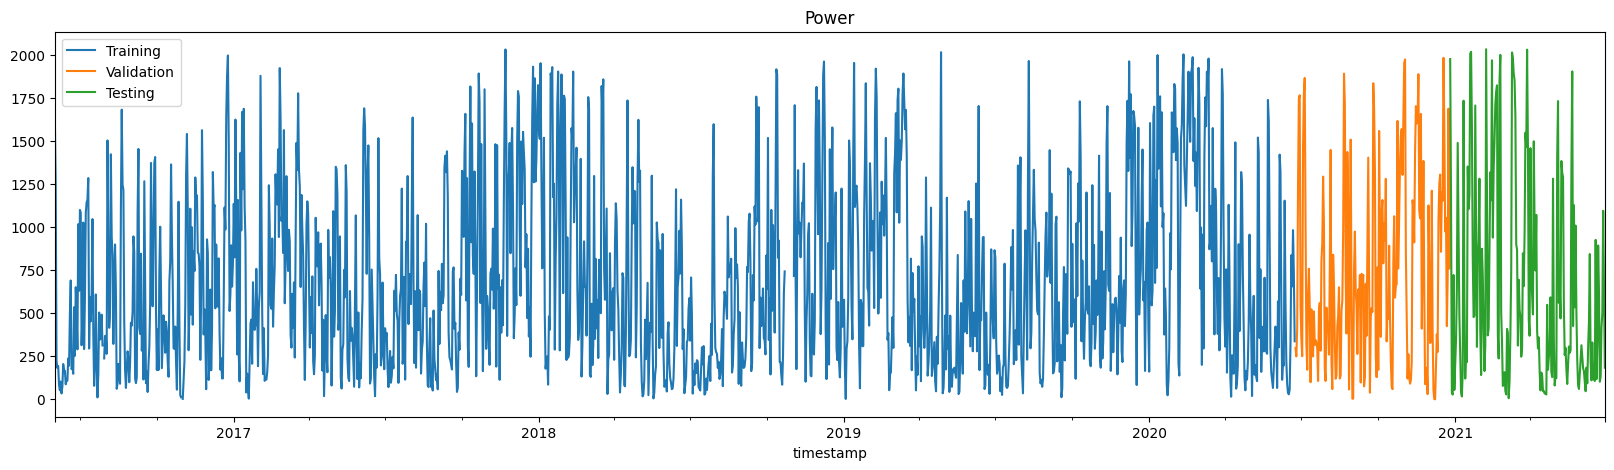

In [6]:
# plot UK data split with different colors for train, val and test
uk_data_preprocessor.plot_data_split(uk_train, uk_val, uk_test)

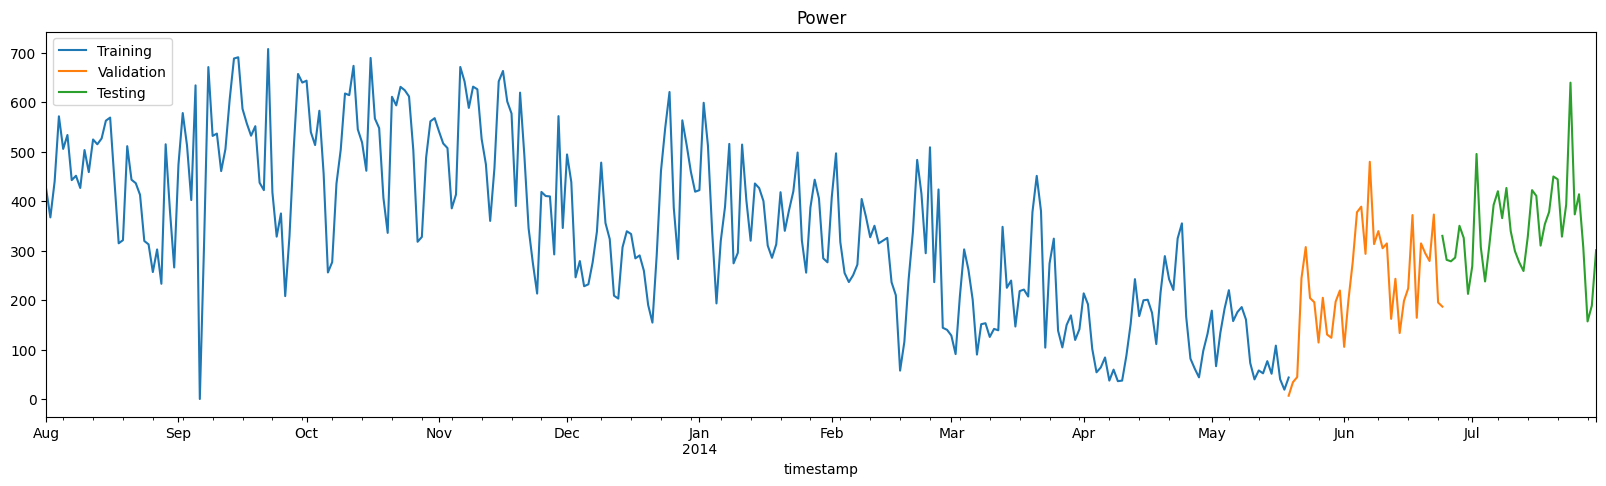

In [7]:
# plot BRAZIL data split with different colors for train, val and test
brazil_data_preprocessor.plot_data_split(brazil_train, brazil_val, brazil_test)

## 4. Split data into features and labels

Next, we are spliting our preprocessed data into features and labels. We have three different labels corresponding to the three different time horizons.

In [8]:
# Split into features and labels
print("Splitting data into features and labels...")
uk_X_train, uk_y_train_next_step, uk_y_train_next_hour, uk_y_train_next_day = uk_data_preprocessor.split_features_labels(
    uk_train)
uk_X_val, uk_y_val_next_step, uk_y_val_next_hour, uk_y_val_next_day = uk_data_preprocessor.split_features_labels(
    uk_val)
uk_X_test, uk_y_test_next_step, uk_y_test_next_hour, uk_y_test_next_day = uk_data_preprocessor.split_features_labels(
    uk_test)

brazil_X_train, brazil_y_train_next_step, brazil_y_train_next_hour, brazil_y_train_next_day = brazil_data_preprocessor.split_features_labels(
    brazil_train)
brazil_X_val, brazil_y_val_next_step, brazil_y_val_next_hour, brazil_y_val_next_day = brazil_data_preprocessor.split_features_labels(
    brazil_val)
brazil_X_test, brazil_y_test_next_step, brazil_y_test_next_hour, brazil_y_test_next_day = brazil_data_preprocessor.split_features_labels(
    brazil_test)

Splitting data into features and labels...


## 5. Train models

After the full data preparation it's time to train the models. For now we implemented XGBoost Regressors which usually perform really well for forecasts and time-series regression tasks.

First, we initialize and train the model. Hyperparameters for the model can be configured in the [config file](./utils/config.py).

In [9]:
# Initialize model
print("Initializing models...")
uk_xgboost = XGBoost(data_type='UK')
brazil_xgboost = XGBoost(data_type='BRAZIL')

# Train xgboost models
print("Training models...")
uk_xgboost.train_models(uk_X_train, uk_y_train_next_step, uk_y_train_next_hour,
                        uk_y_train_next_day, uk_X_val, uk_y_val_next_step, uk_y_val_next_hour, uk_y_val_next_day)
brazil_xgboost.train_models(brazil_X_train, brazil_y_train_next_step, brazil_y_train_next_hour,
                            brazil_y_train_next_day, brazil_X_val, brazil_y_val_next_step, brazil_y_val_next_hour, brazil_y_val_next_day)

Initializing models...
Training models...


Let's have a quick look at the different feature importances for the next step and next day models for both, uk and brazil data.

Interestingly, the next step and next day models (for both data types) differ in their most important features.

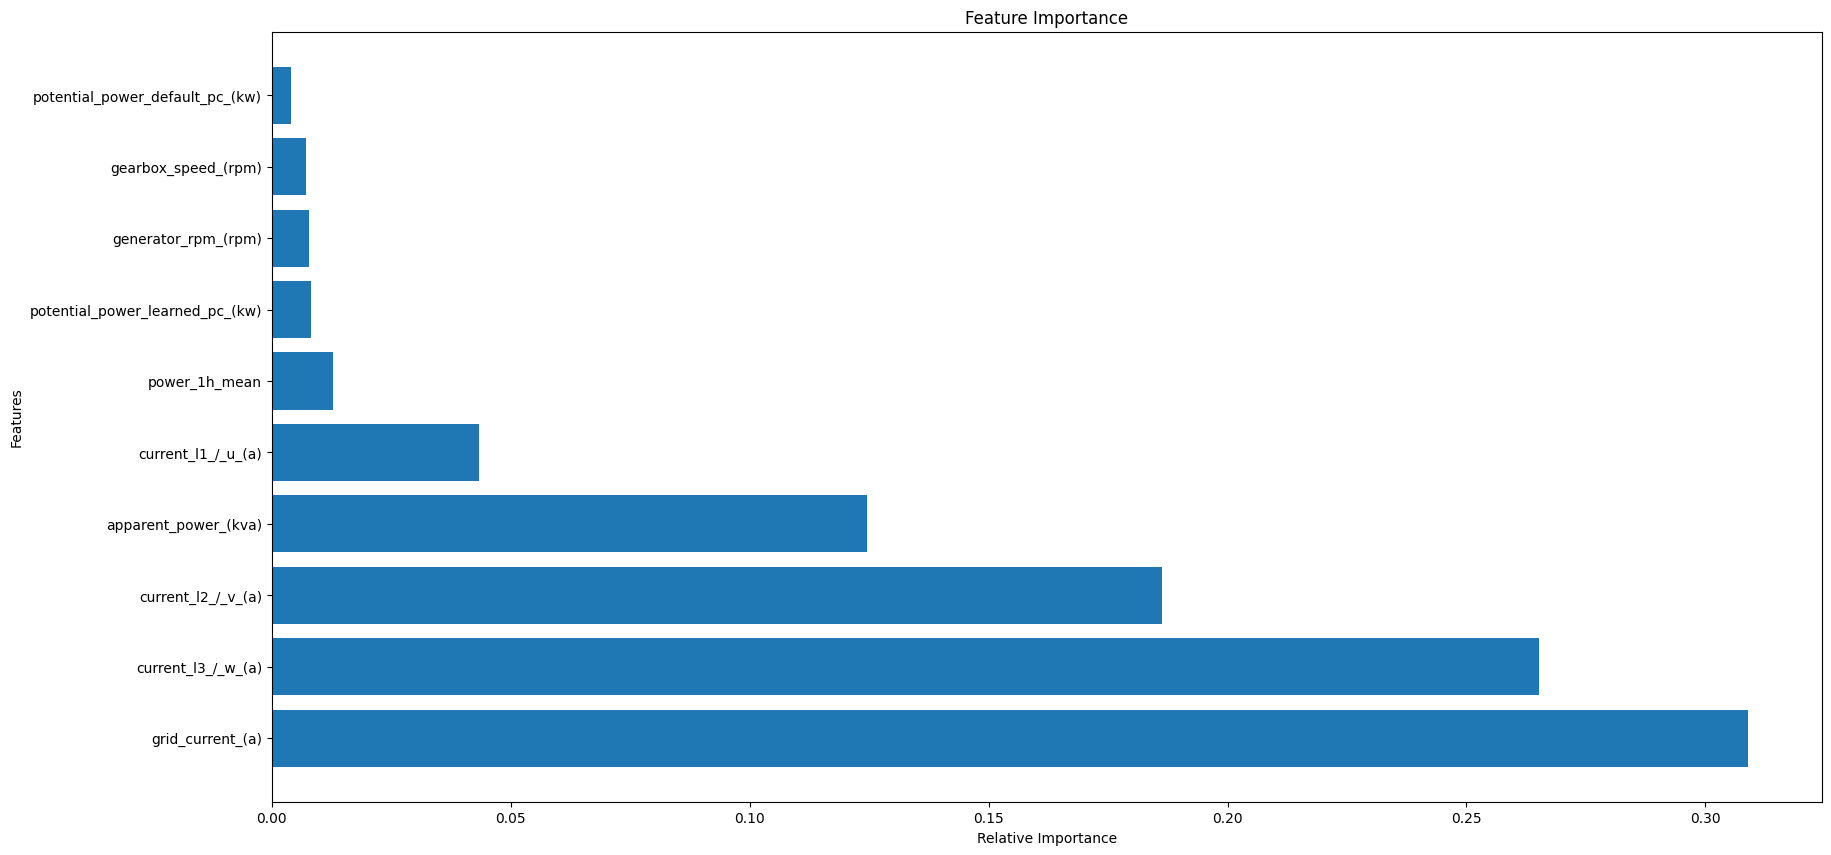

In [10]:
# Plot feature importances of 10 most important of uk next step xgboost model
uk_xgboost.plot_feature_importances(uk_X_train.columns)

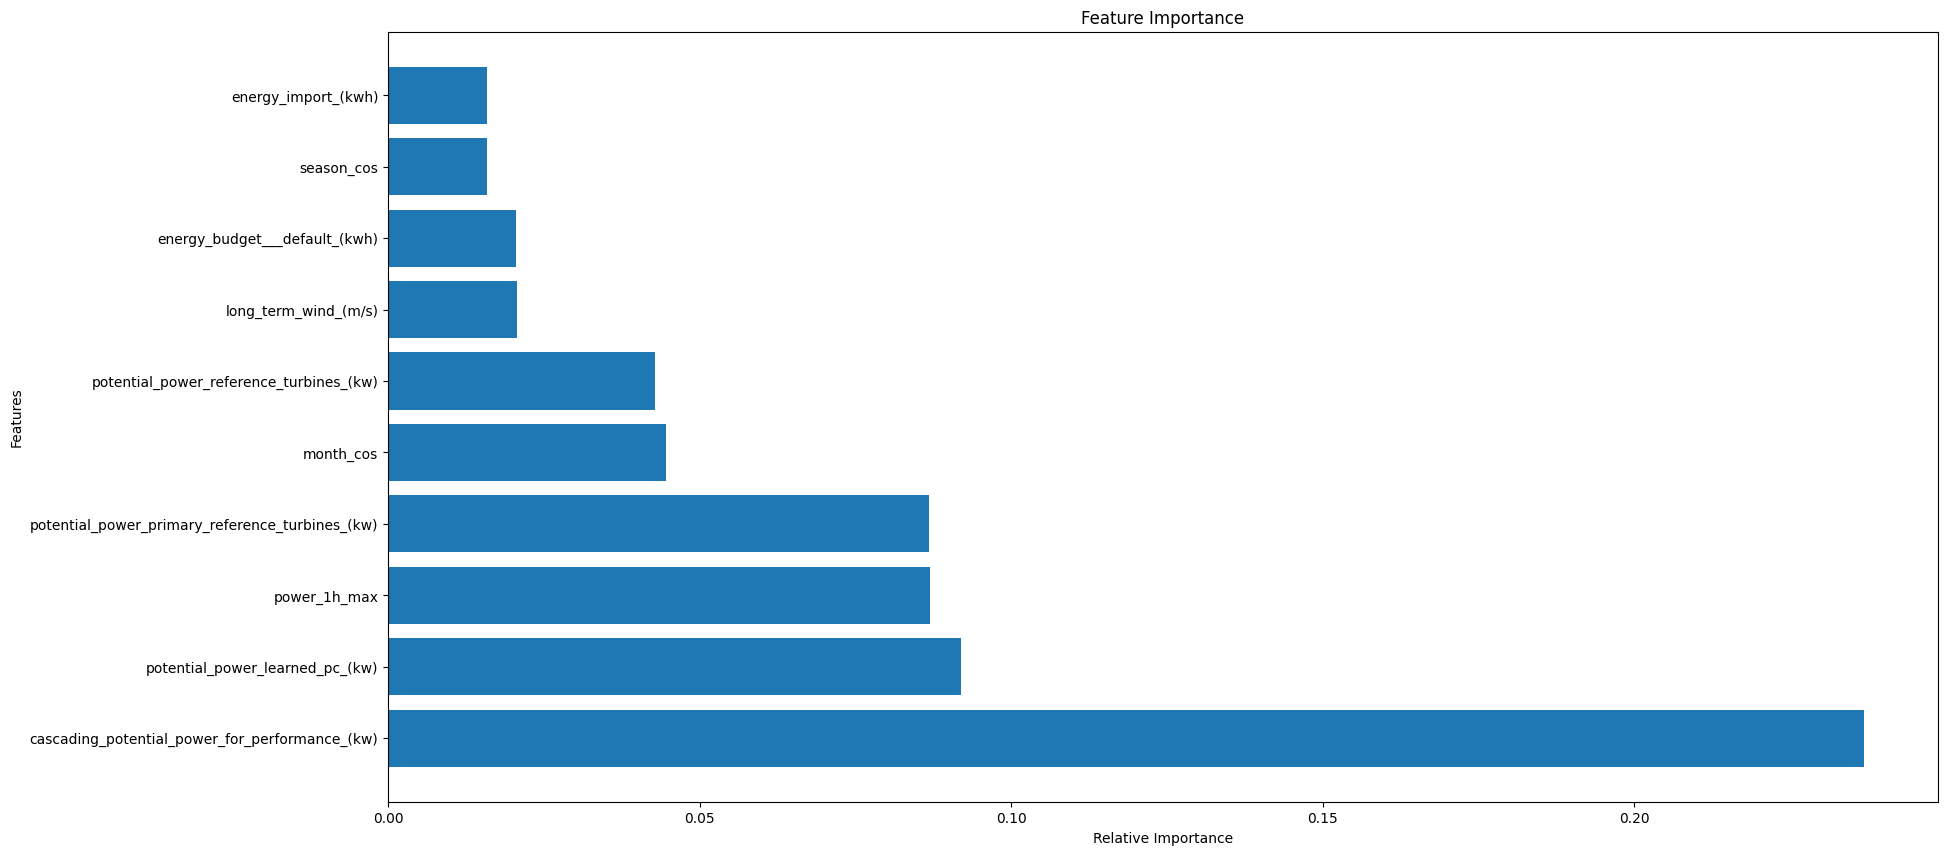

In [11]:
# Plot feature importances of 10 most important of uk next day xgboost model
uk_xgboost.plot_feature_importances(uk_X_train.columns, model_type='next_day')

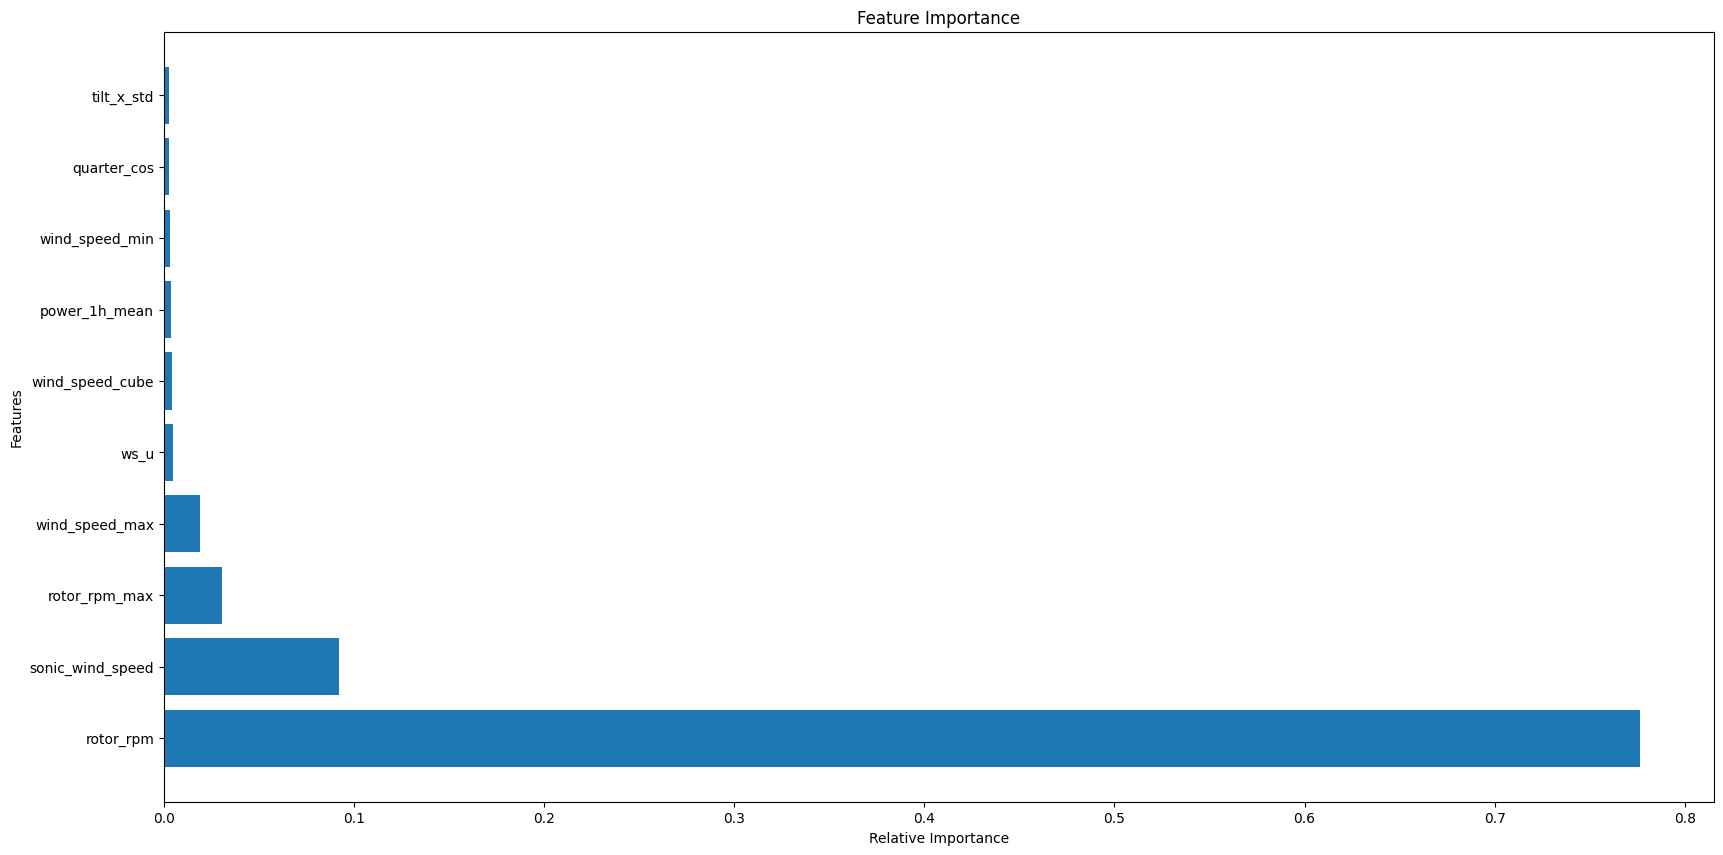

In [12]:
# Plot feature importances of 10 most important of brazil next step xgboost model
brazil_xgboost.plot_feature_importances(brazil_X_train.columns)

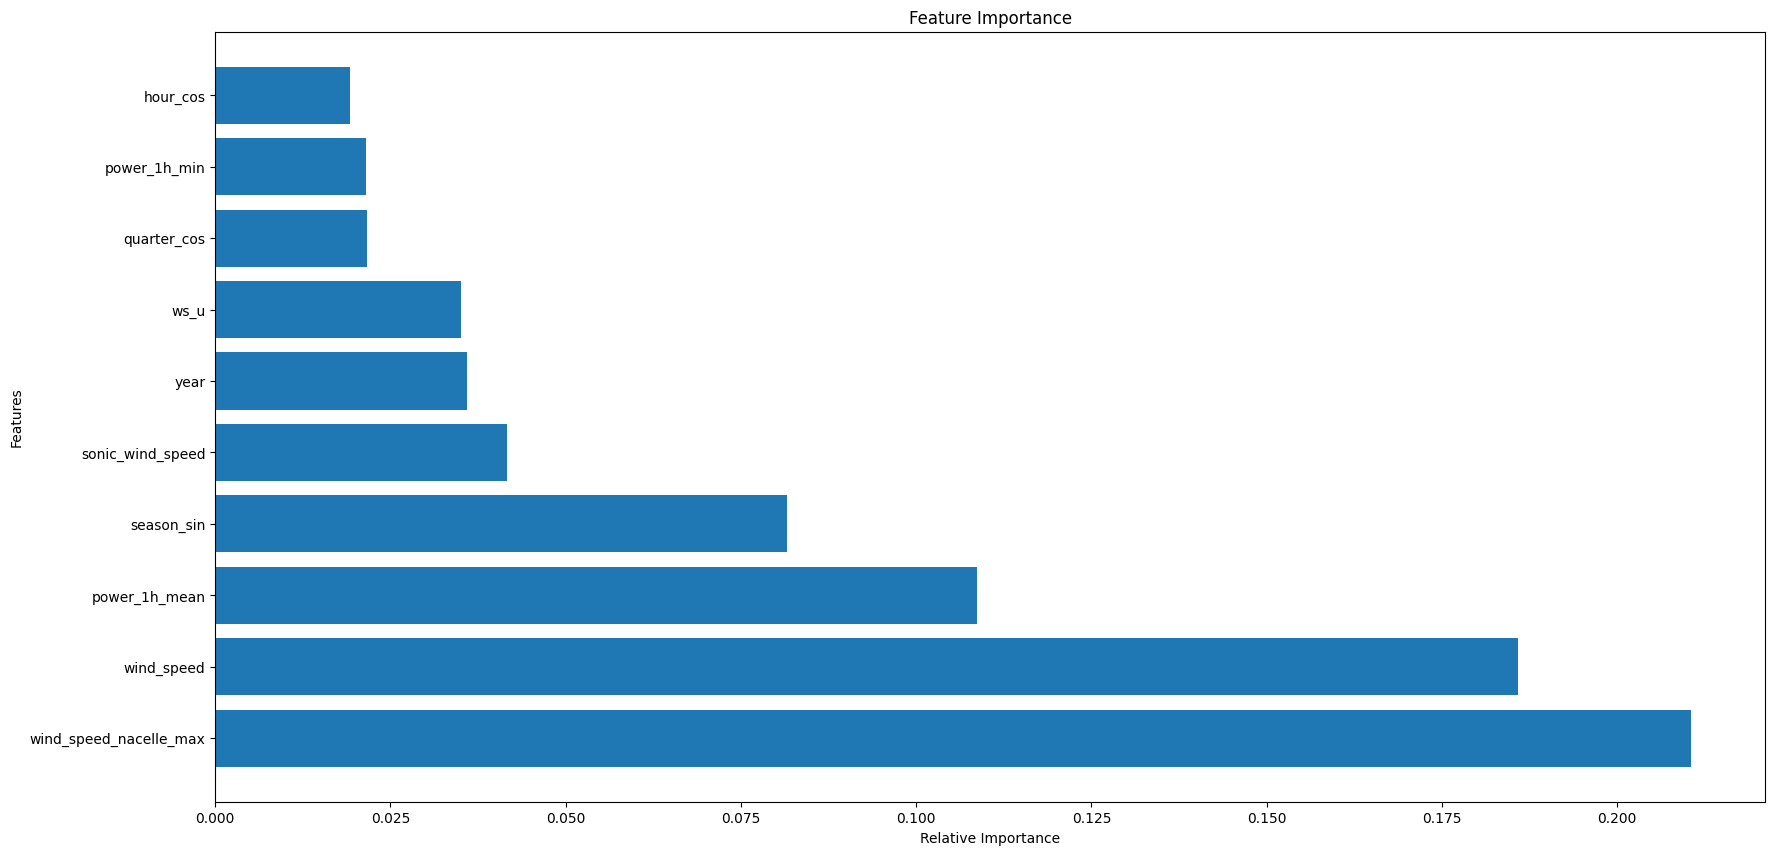

In [13]:
# Plot feature importances of 10 most important of brazil next day xgboost model
brazil_xgboost.plot_feature_importances(
    brazil_X_train.columns, model_type='next_day')

## 5. Forecasting the power output & model evaluation

Now that the models are trained, let's make some actual predictions and compare them to the actual results (test data). 

In [14]:
# Make predictions for next step, next hour, next day
print("Making predictions...")
uk_y_pred_next_step, uk_y_pred_next_hour, uk_y_pred_next_day = uk_xgboost.predict_models(
    uk_X_test)
brazil_y_pred_next_step, brazil_y_pred_next_hour, brazil_y_pred_next_day = brazil_xgboost.predict_models(
    brazil_X_test)

Making predictions...


When looking at the following plots we can clearly see that for both data types the models perform better for nearer time horizons, meaning the best models are the next step models and the worst are the next day models.

Plotting predictions vs actual data ...


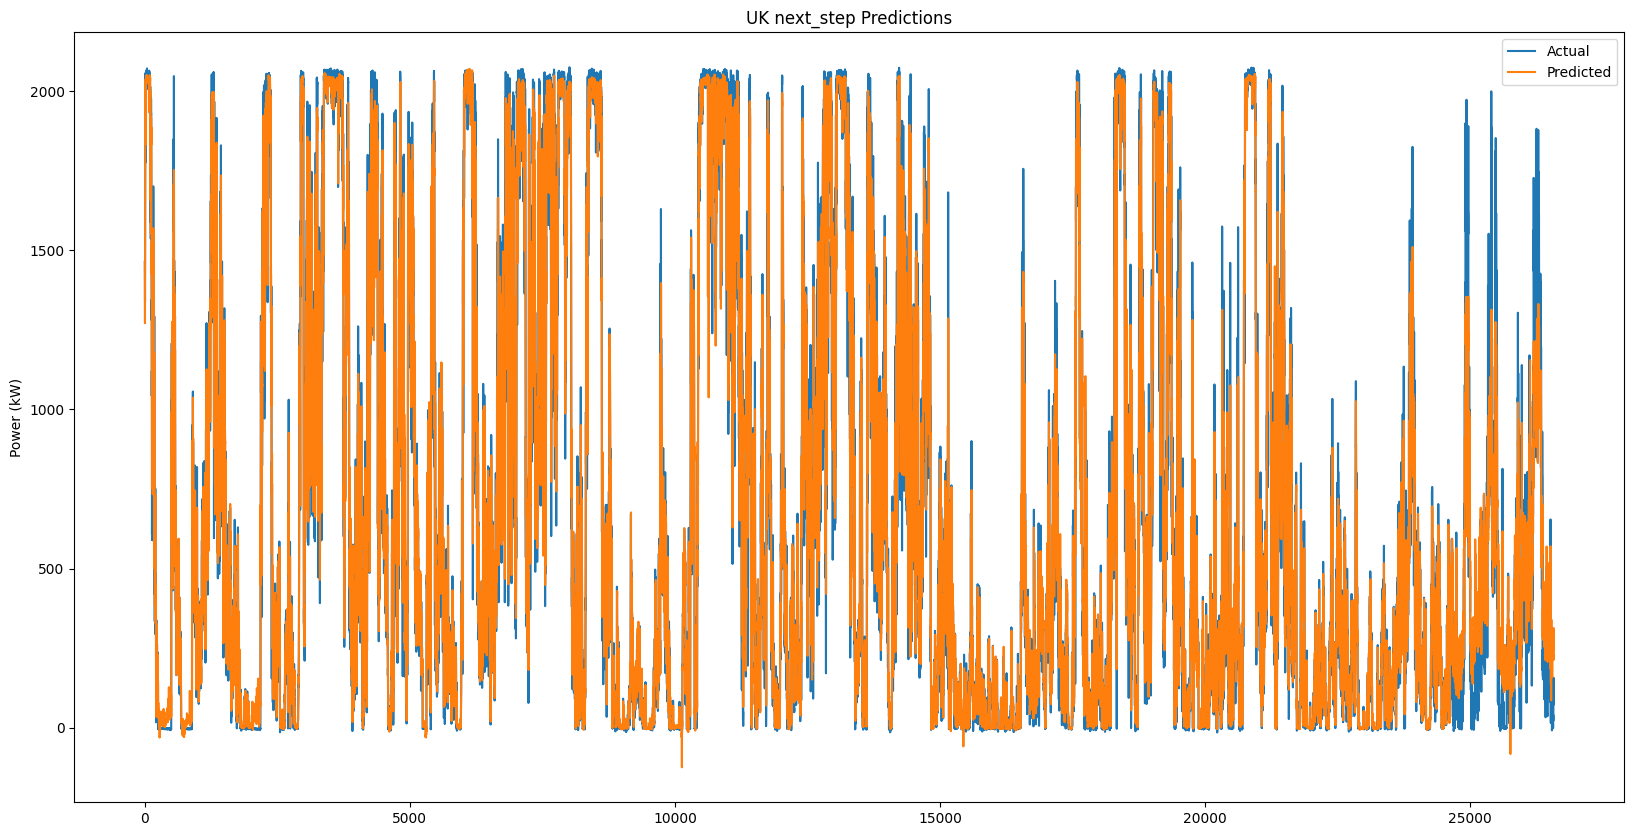

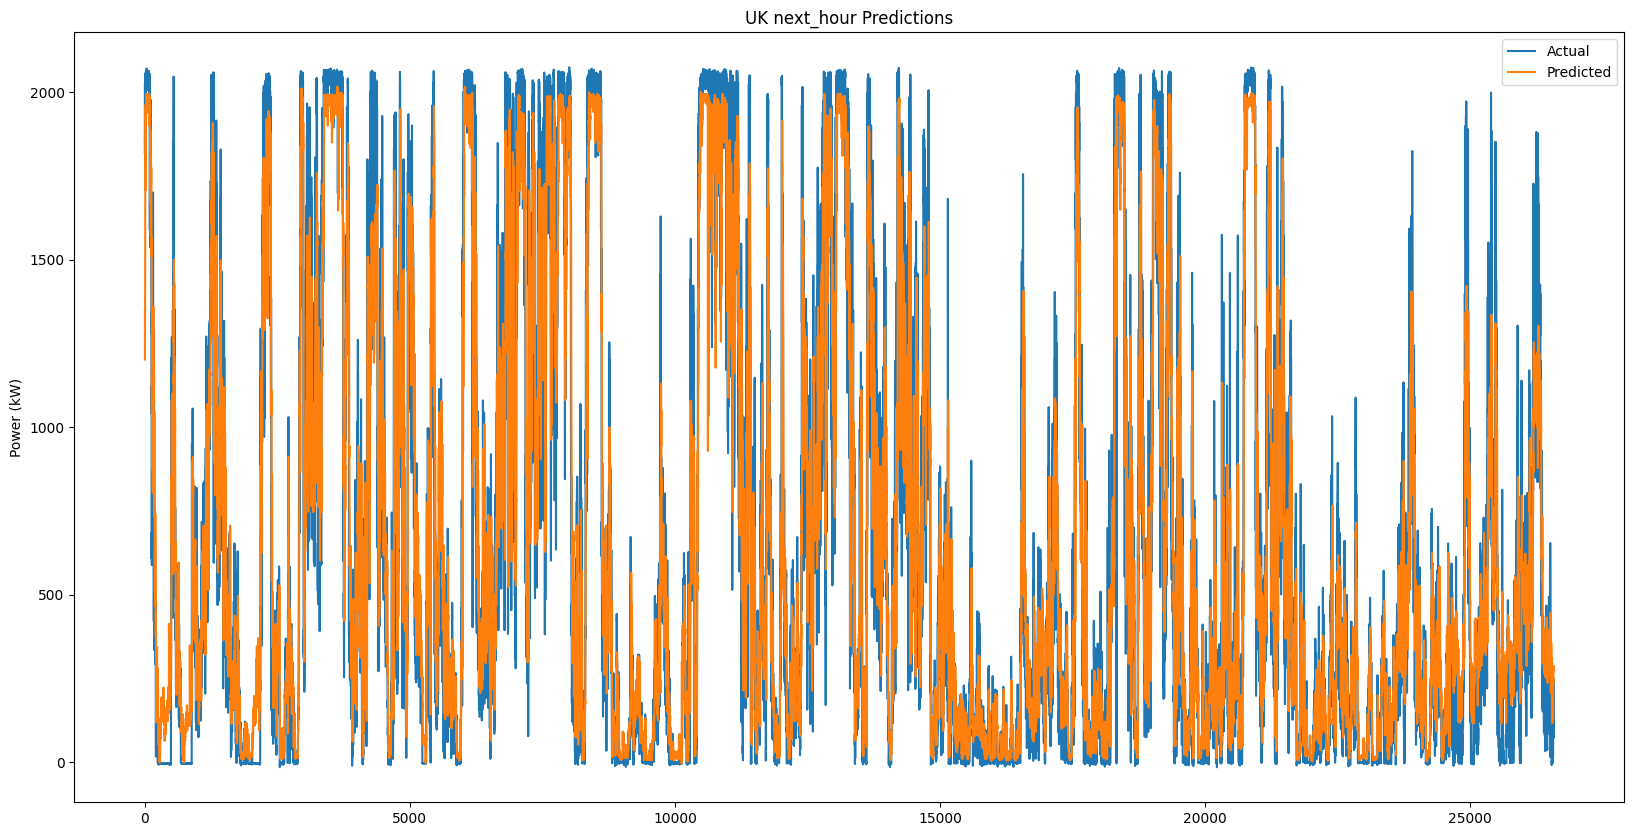

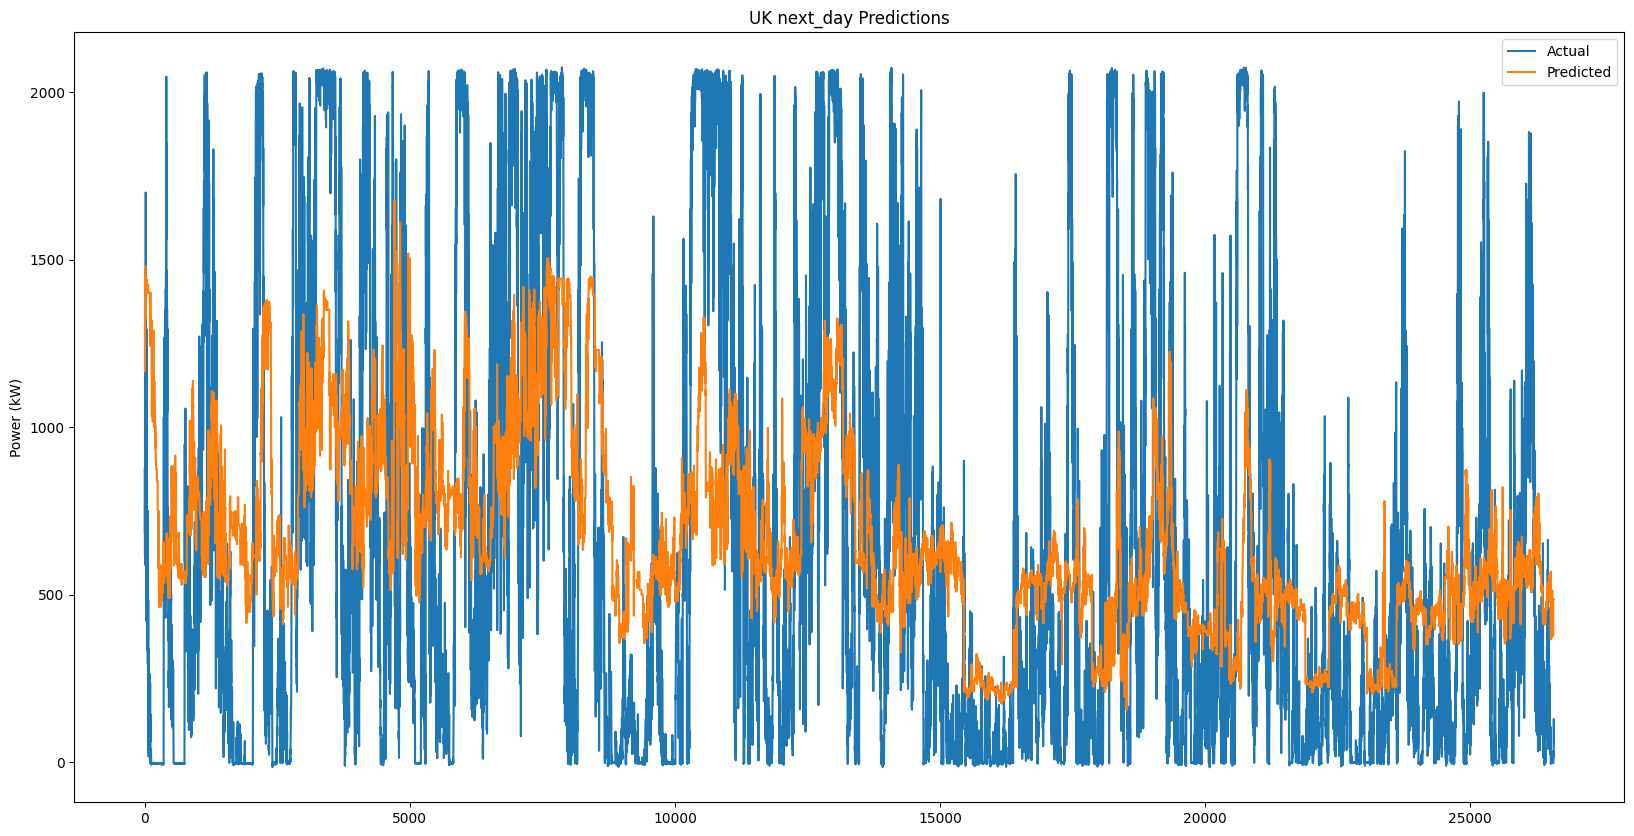

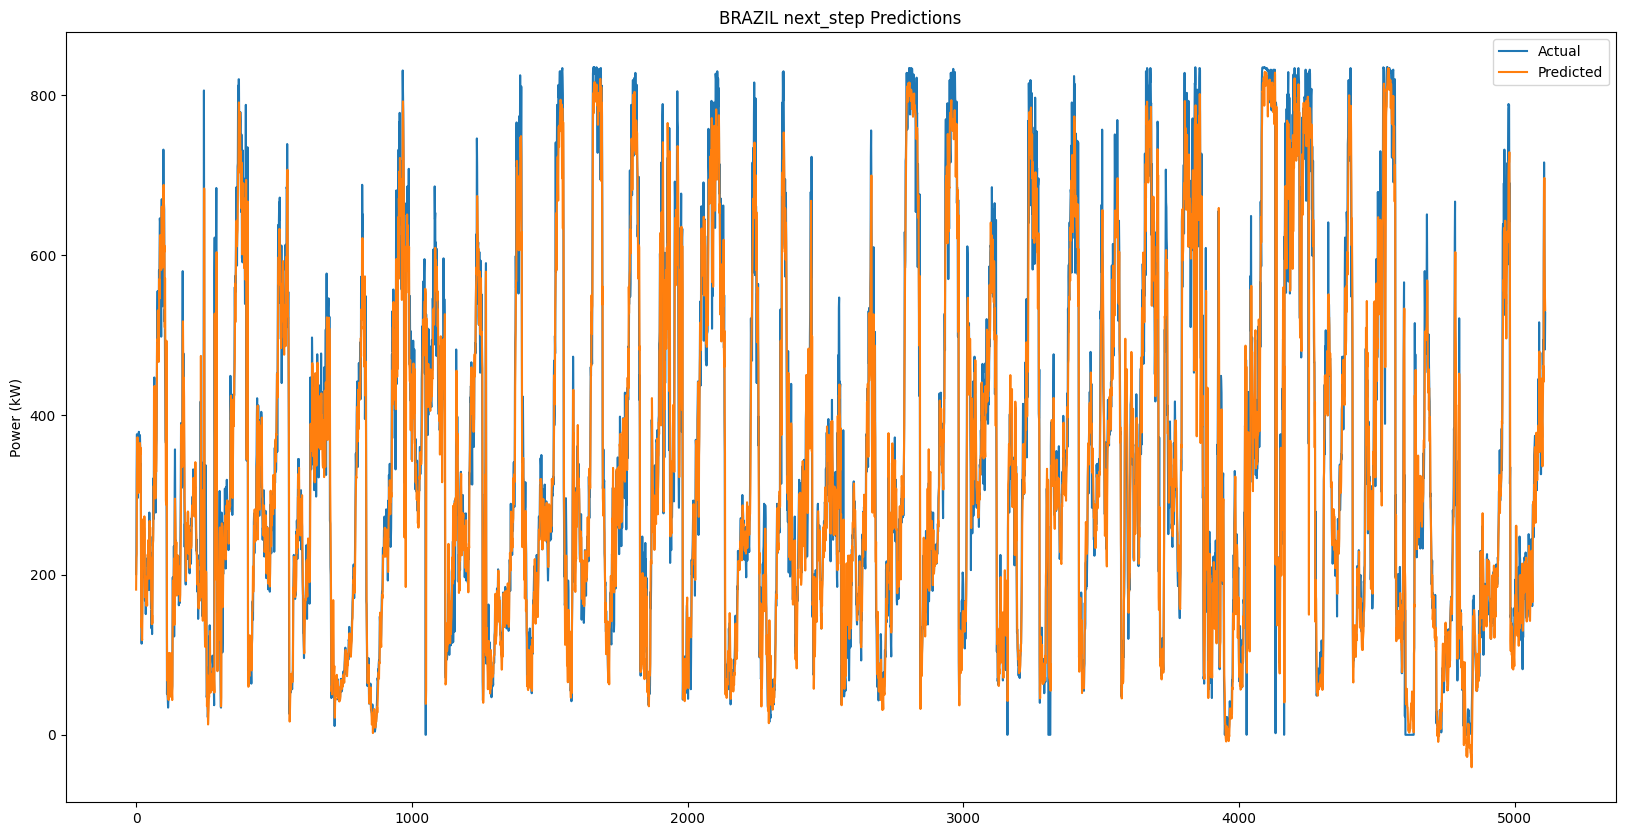

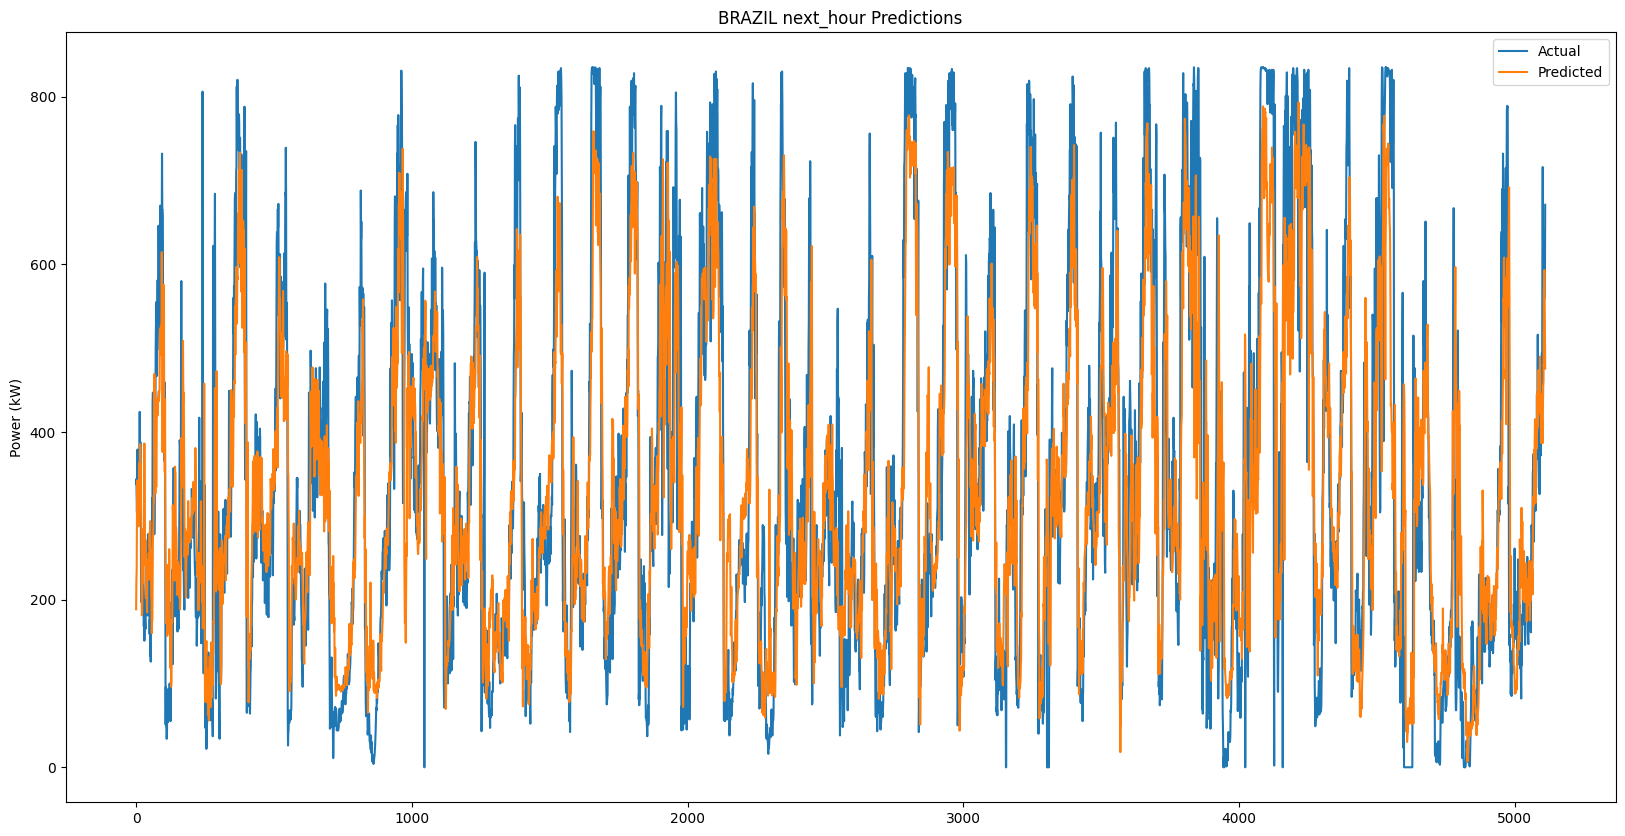

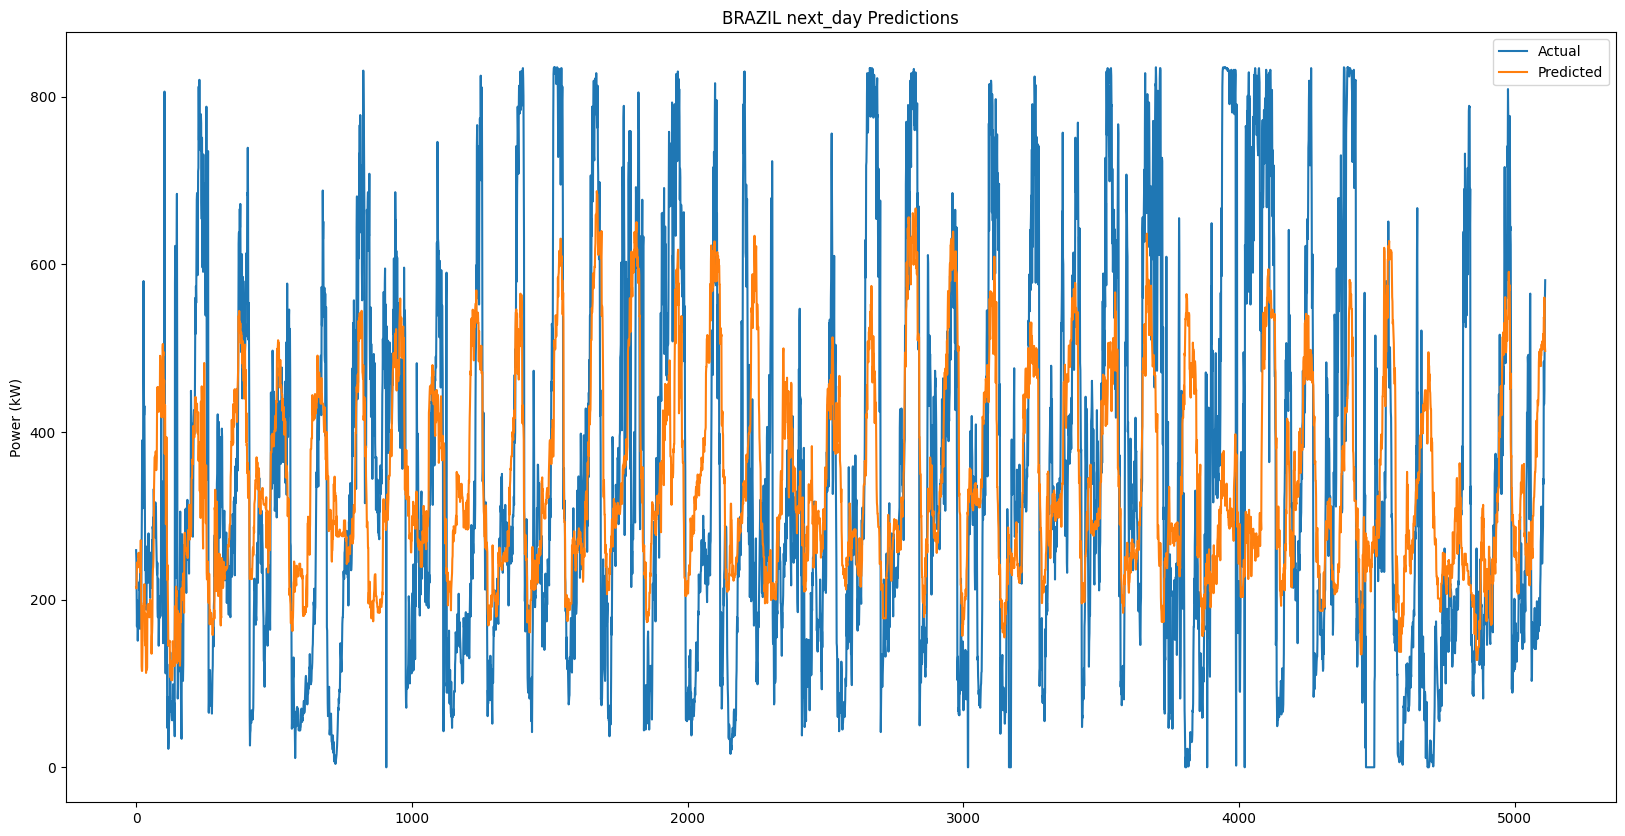

In [15]:
# Plot predictions and save prediction plots
print("Plotting predictions vs actual data ...")
next_step_path, next_hour_path, next_day_path = uk_xgboost.save_prediction_plots(
    uk_y_test_next_step, uk_y_test_next_hour, uk_y_test_next_day, uk_y_pred_next_step, uk_y_pred_next_hour, uk_y_pred_next_day)

next_step_path, next_hour_path, next_day_path = brazil_xgboost.save_prediction_plots(
    brazil_y_test_next_step, brazil_y_test_next_hour, brazil_y_test_next_day, brazil_y_pred_next_step, brazil_y_pred_next_hour, brazil_y_pred_next_day)

Let's have a closer look at the evaluation metrics MAE and RMSE and compare them to the [benchmark](../benchmark_wind.csv).

For the UK forecast we have slightly beaten the benchmark.
For the Brazil forecast however the benchmark is slighlty better, so there would still be some investigation to do. We have already come up with improvement suggestions in the [README](../README.md) on how to further improve the current implementation.

In [16]:
# Print evaluation metrics of uk models
print("Evaluating uk models...")
uk_xgboost.evaluate_models(uk_y_test_next_step, uk_y_test_next_hour, uk_y_test_next_day,
                           uk_y_pred_next_step, uk_y_pred_next_hour, uk_y_pred_next_day)

Evaluating uk models...


,MAE,benchmark_MAE,RMSE,benchmark_RMSE
next_step,85.047391,91.553768,134.525255,145.602811
next_hour,164.010406,183.285915,240.182866,263.749456
next_day,490.846144,510.709616,606.197941,623.023208


In [17]:
# Print evaluation metrics of brazil models
print("Evaluating brazil models...")
brazil_xgboost.evaluate_models(brazil_y_test_next_step, brazil_y_test_next_hour, brazil_y_test_next_day,
                               brazil_y_pred_next_step, brazil_y_pred_next_hour, brazil_y_pred_next_day)

Evaluating brazil models...


,MAE,benchmark_MAE,RMSE,benchmark_RMSE
next_step,41.725977,36.244988,61.959219,55.417200
next_hour,92.179924,81.943719,125.347495,119.249865
next_day,150.136643,151.508157,192.657962,196.741606


## [7. Save Models]

Optionally, we save the models for later use.

In [18]:
# Save models
print("Saving models...")
model_path = uk_xgboost.save_models(config.UK_DATA_PATH + "models")
print(f"Saved UK models to {model_path}")
model_path = brazil_xgboost.save_models(config.BRAZIL_DATA_PATH + "models")
print(f"Saved Brazil models to {model_path}")

Saving models...
Saved models to ../data/uk/models!
Saved UK models to ../data/uk/models
Saved models to ../data/brazil/models!
Saved Brazil models to ../data/brazil/models
